In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir(r'C:\Users\82104\DM\project')

from tqdm import notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist, pdist

import warnings
warnings.filterwarnings('ignore')

#### (1차)구별로 했을 때 들어가야하는 변수 => 논문 의거x & 구별 데이터 => Clustering


- 운행효율성, 물동량 수, 타켓인구, 매출액, 점포 수, 공시지가

#### (2차) 입지 후보군(구별)에서 최적입지 선정할 때 사용되는 변수 => 논문 의거o & 주유소별 데이터 => Classification


- 개별공시지가, 공급처 접근성(east, west, koreaDC), 면적, 근처 지역 인구수, 생산가능인구(인력출원여부)

We will use some datasets, subtract required column and merge by distrcit.(Gangnam, Ganbuk, Gangdong, ...)  
First, Find the distrcit where MFC(Micro Fullfillment Center) is needed with clustering.  
Second, Set up the optimal center in district by using Score, and then make classification model(Self-supervising)

In [2]:
df_table = pd.read_csv(r'data_for_EDA.csv') # import preprocessing file

In [3]:
df_table.head()

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000


## First step. Choose district where MFC is required.(Clustering)

In [4]:
col_name = df_table.columns.drop(['DISTRICT']).to_list()
col_name

['DRIVEN_EFF', 'TOTAL_LOGIS', 'POP2040', 'TOTAL_SALES', 'NUM_STORE', 'ESTATE']

In [5]:
df_scaling = df_table[col_name]
df_scaling

,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,0.027219,2400374,166805,4.447564e+12,66655,5198000
1,0.131360,2250955,112398,6.805869e+12,62840,10079000
2,0.054334,2442377,184583,2.806535e+12,69651,4109000
3,0.026526,2507172,215172,1.834499e+12,57391,3911000
4,0.159699,2165093,185381,6.456707e+12,117682,11141000
5,0.142776,2067762,191766,4.087616e+12,99849,9213000
6,0.082233,2484878,199990,1.380648e+12,52834,4507000
7,0.017854,2202978,122596,1.482913e+12,48726,3705000
8,0.111866,2034893,126118,1.210447e+12,40786,3451000
9,0.066146,2201708,111478,3.490343e+12,55524,3870000


In [6]:
# StandardScalaer
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
s_scaled = s_scaler.fit_transform(df_scaling)
pd.DataFrame(s_scaled, columns=col_name)

,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE
0,-1.136150,0.227904,-0.197550,0.290781,-0.345691,-0.461560
1,1.346835,-0.703058,-1.124559,1.234272,-0.450148,0.939167
2,-0.489647,0.489605,0.105360,-0.365747,-0.263659,-0.774076
3,-1.152681,0.893314,0.626548,-0.754631,-0.599345,-0.830897
4,2.022516,-1.238025,0.118956,1.094582,1.051459,1.243935
5,1.619030,-1.844450,0.227747,0.146777,0.563181,0.690647
6,0.175537,0.754410,0.367871,-0.936204,-0.724118,-0.659860
7,-1.359439,-1.001981,-0.950802,-0.895290,-0.836598,-0.890014
8,0.882044,-2.049242,-0.890792,-1.004296,-1.054000,-0.962906
9,-0.208040,-1.009894,-1.140235,-0.092175,-0.650464,-0.842663


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6) 
values_pca = pca.fit_transform(s_scaled)
principalDf = pd.DataFrame(data=values_pca, columns = ['PC1', 'PC2','PC3', 'PC4', 'PC5', 'PC6'])
principalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.484454,-0.823491,0.285771,0.790487,0.377218,-0.192964
1,1.235587,1.702674,0.624046,0.020308,1.163901,0.103416
2,-0.893321,-0.611083,0.128440,-0.021362,-0.072842,-0.315191
3,-1.456038,-1.414561,-0.074750,-0.067021,-0.066145,0.053230
4,2.276727,1.853433,-0.770652,-0.513856,0.034141,-0.103255


In [8]:
print('Explained variance ratio :', pca.explained_variance_ratio_)
pca_ratio = pd.DataFrame({'Explained variance':pca.explained_variance_,
             'Explained variance ratio':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(s_scaled.shape[1])]))
pca_ratio['Cumulative ratio'] = pca_ratio['Explained variance ratio'].cumsum()
pca_ratio

Explained variance ratio : [0.4736976  0.25002054 0.16547079 0.08416489 0.02014256 0.00650362]


,Explained variance,Explained variance ratio,Cumulative ratio
pca1,2.960610,0.473698,0.473698
pca2,1.562628,0.250021,0.723718
pca3,1.034192,0.165471,0.889189
pca4,0.526031,0.084165,0.973354
pca5,0.125891,0.020143,0.993496
pca6,0.040648,0.006504,1.000000


We choose the number of pca that Explained variance is more than 0.7 and culmuative ratio is over 80%.  
So, up to PCA3 is suitable.

In [9]:
pca = PCA(n_components=3) 
values_pca = pca.fit_transform(s_scaled)
principalDf = pd.DataFrame(data=values_pca, columns = ['PC1', 'PC2', 'PC3'])
print('Explained variance ratio :', pca.explained_variance_ratio_)

Explained variance ratio : [0.4736976  0.25002054 0.16547079]


In [10]:
principalDf

,PC1,PC2,PC3
0,-0.484454,-0.823491,0.285771
1,1.235587,1.702674,0.624046
2,-0.893321,-0.611083,0.128440
3,-1.456038,-1.414561,-0.074750
4,2.276727,1.853433,-0.770652
5,1.086889,2.072185,-1.127754
6,-1.306736,-0.302939,0.062040
7,-1.685496,0.244173,0.386300
8,-1.533691,2.420291,-0.248251
9,-0.910535,0.987625,0.464274


## Hierarchy Clustering

In [11]:
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

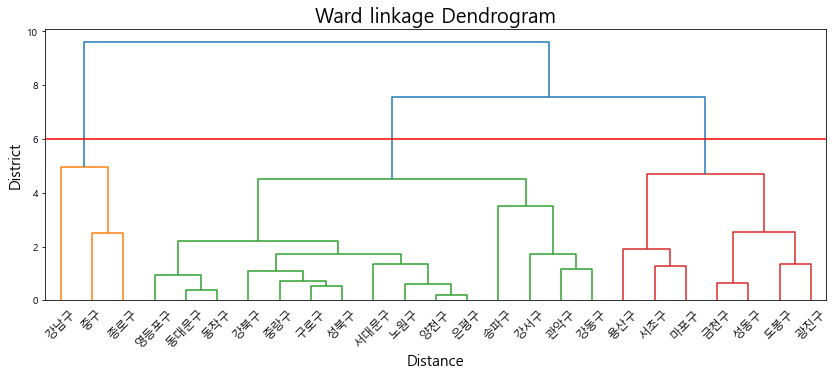

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

plt.figure(figsize=(14, 5))
ax = plt.subplot(111)
dendrogram(linkage(values_pca, method='ward', metric = 'euclidean'), labels = df_table['DISTRICT'].values, leaf_font_size=12)
plt.axhline(y = 6, color = 'red') 
plt.title('Ward linkage Dendrogram', size=20)
plt.xlabel('Distance', size=15)
plt.ylabel('District', size=15)
plt.show()

Using Ward method, We can cluster for 3 groups.
- 강남구, 중구, 종로구(CLUSTER=0)
- 영등포구, 동대문구, 동작구, 강북구, 중랑구, 구로구, 성북구, 서대문구, 노원구, 양천구, 은평구, 송파구, 강서구, 관악구, 강동구(CLUSTER=1)
- 용산구, 서초구, 마포구, 금천구, 성동구, 도봉구, 광진구(CLUSTER=2)

In [13]:
df_hcluster = df_table.copy()

In [14]:
df_hcluster['CLUSTER'] = 0

In [15]:
list1 = ['영등포구', '동대문구', '동작구', '강북구', '중랑구', '구로구', '성북구', '서대문구', '노원구', '양천구', '은평구', '송파구', '강서구', '관악구', '강동구']
list2 = ['용산구', '서초구', '마포구', '금천구', '성동구', '도봉구', '광진구']

In [16]:
df_hcluster.loc[df_hcluster['DISTRICT'].isin(list1), 'CLUSTER'] = 1
df_hcluster.loc[df_hcluster['DISTRICT'].isin(list2), 'CLUSTER'] = 2
# df_hcluster.loc[df_hcluster['DISTRICT'].isin(list3), 'CLUSTER'] = 3

In [17]:
df_hcluster

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,1
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,2
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,1
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,2
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,2
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,2
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,2


In [18]:
hcluster0 = df_hcluster[df_hcluster['CLUSTER'] == 0]
hcluster1 = df_hcluster[df_hcluster['CLUSTER'] == 1]
hcluster2 = df_hcluster[df_hcluster['CLUSTER'] == 2]
# hcluster3 = df_hcluster[df_hcluster['CLUSTER'] == 3]

Text(0.5, 1.0, 'ESTATE')

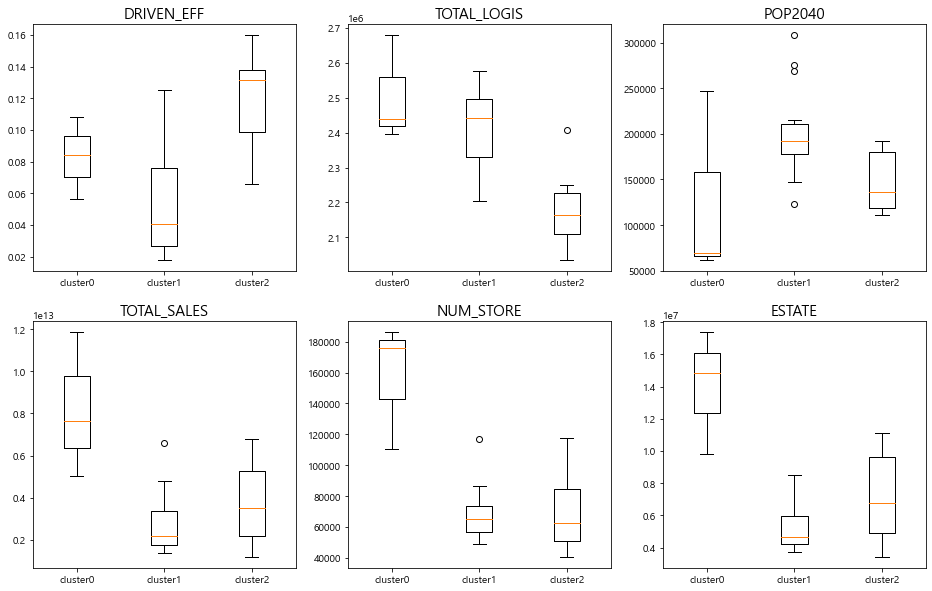

In [19]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
# ax7 = fig.add_subplot(4,3,7)
# ax8 = fig.add_subplot(4,3,8)
# ax9 = fig.add_subplot(4,3,9)
# ax10 = fig.add_subplot(4,3,10)



ax1.boxplot([hcluster0.DRIVEN_EFF, hcluster1.DRIVEN_EFF, hcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF(평균 주행거리) 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([hcluster0.TOTAL_LOGIS, hcluster1.TOTAL_LOGIS, hcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([hcluster0.POP2040, hcluster1.POP2040, hcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([hcluster0.TOTAL_SALES, hcluster1.TOTAL_SALES, hcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([hcluster0.NUM_STORE, hcluster1.NUM_STORE, hcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([hcluster0.ESTATE, hcluster1.ESTATE, hcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

In [20]:
hcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '영등포구', '중랑구', '관악구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '동작구', '은평구'], dtype=object)

### Hierarchy Clustering Analysis Result

- cluster0
    - 물류량이 가장 많으며 우수한 소비력과 대규모 상권
    - 물류 수요량이 많지만 상권도 크기 때문에 언택트 소비가 작을 것으로 예상됨
    - 인구수가 적으므로 수요증가량을 기대하기 어려움
    - 공시지가가 가장 크다 -> MFC 입지에 부적합
    
- cluster1
    - 물류량 및 인구수 준수함
    - 소규모 상권, 오프라인 소비력이 높기 때문에 언택스 소비량이 클 것이라고 예상할 수 있음
    - 공시지가와 운행 효율이 낮음 -> MFC 입지에 적합
    
- cluster2
    - 공시지가는 높지 않음
    - 하지만 물류량은 가장 낮으면서 운행 효율이 가장 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC 입지에 부적합

#### 따라서 cluster1이 MFC 입지에 가장 적합

## K-means Clustering

In [21]:
# https://github.com/blings0611/Finding-New-Location-of-Wheel-Chair-Charging-Station/blob/master/2.%20CLUSTERING/BARRIER_FREE_FINAL.ipynb
from sklearn.cluster import KMeans
def elbow_method(data):
    K = range(1,8) 
    KM = [KMeans(n_clusters=k, random_state=100).fit(data) for k in K] 
    centroids = [k.cluster_centers_ for k in KM] 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids] 
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    

    # Elbow curve
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    
    kIdx = 2
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=15, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    kIdx = 3
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=10, 
    markeredgewidth=2, markeredgecolor='b', markerfacecolor='None')
    
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-Means clustering')

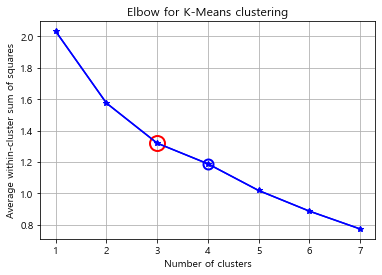

In [22]:
elbow_method(values_pca)

In hierarchical clustering, we divide to 3 groups. Also according to elbow method, we select number 3 as the number of groups.

In [23]:
kmeans = KMeans(init='k-means++', n_clusters=3, random_state=100) # Opitmal K = 3
kmeans.fit(values_pca)

KMeans(n_clusters=3, random_state=100)

In [24]:
values_pca[:,0]

array([-0.4844543 ,  1.23558748, -0.89332056, -1.45603787,  2.27672684,
        1.08688862, -1.30673585, -1.6854964 , -1.53369094, -0.91053517,
        0.06187967, -1.29107118, -0.47666988, -0.34740124,  5.15454057,
        3.77613727, -1.13745788, -1.20058391,  1.25466409, -0.77584858,
       -0.26596698,  1.41516297, -0.86347716, -0.38623549, -1.24660413])

In [25]:
principalDf['DISTRICT'] = df_table['DISTRICT']
principalDf

,PC1,PC2,PC3,DISTRICT
0,-0.484454,-0.823491,0.285771,동대문구
1,1.235587,1.702674,0.624046,용산구
2,-0.893321,-0.611083,0.128440,구로구
3,-1.456038,-1.414561,-0.074750,노원구
4,2.276727,1.853433,-0.770652,서초구
5,1.086889,2.072185,-1.127754,마포구
6,-1.306736,-0.302939,0.062040,성북구
7,-1.685496,0.244173,0.386300,강북구
8,-1.533691,2.420291,-0.248251,도봉구
9,-0.910535,0.987625,0.464274,금천구


In [26]:
kmeans.cluster_centers_

array([[-0.76846774, -0.49049657, -0.08311051],
       [ 0.54362215,  1.98585984, -0.43179779],
       [ 3.44861361, -0.53028583,  1.19062254]])

In [27]:
kmeans.cluster_centers_[:2, 0]

array([-0.76846774,  0.54362215])

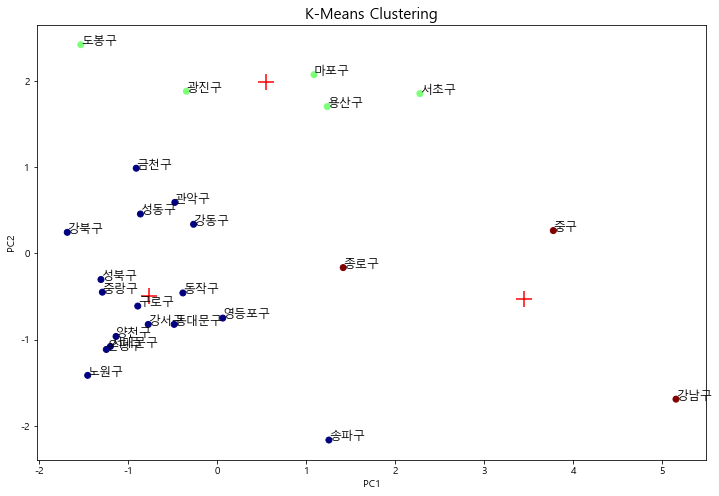

In [28]:
# Kmeans 시각화 부분 pca
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.scatter(values_pca[:,0], values_pca[:,1], c=kmeans.labels_, cmap='jet')
plt.scatter(kmeans.cluster_centers_[:3, 0], kmeans.cluster_centers_[:3, 1], s=250, marker='+', c='red', edgecolor='black',
    label='centroids'
)
for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('K-Means Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

4 Groups
- '동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구','양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구(CLUSTER=0)
- 도봉구, 광진구, 마포구, 용산구, 서초구(CLUSTER=1)
- 강남구, 중구, 종로구(CLUSTER=2)

In [29]:
kmeans.labels_

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0])

In [30]:
df_ktable = df_table.copy()

In [31]:
df_ktable['CLUSTER']=kmeans.labels_

In [32]:
df_ktable

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,0
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,1
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,0
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,0
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,1
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,1
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,0
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,0
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,1
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,0


In [33]:
kcluster0 = df_ktable[df_ktable['CLUSTER'] == 0]
kcluster1 = df_ktable[df_ktable['CLUSTER'] == 1]
kcluster2 = df_ktable[df_ktable['CLUSTER'] == 2]
# kcluster3 = df_ktable[df_ktable['CLUSTER'] == 3]

Text(0.5, 1.0, 'ESTATE')

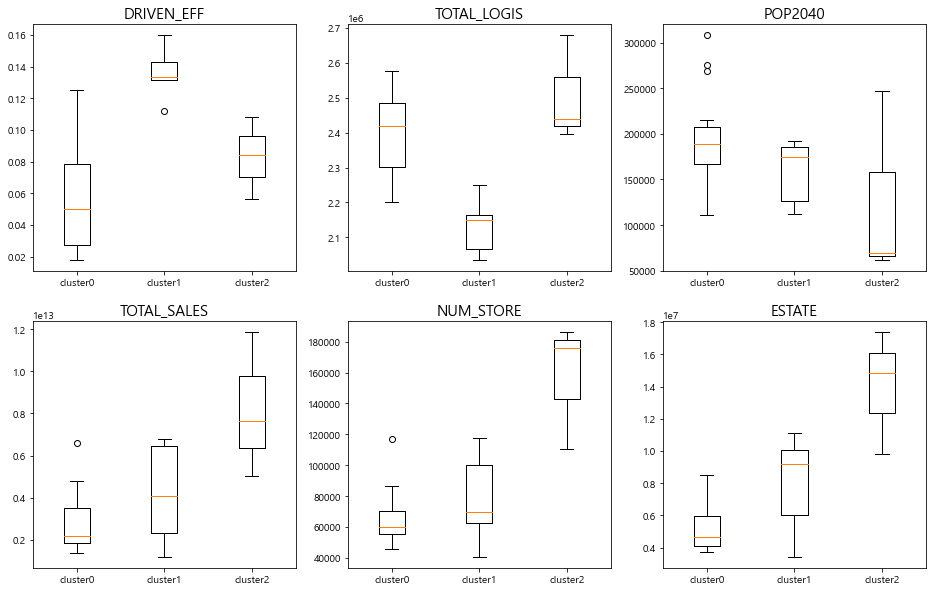

In [34]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
# ax7 = fig.add_subplot(4,3,7)
# ax8 = fig.add_subplot(4,3,8)
# ax9 = fig.add_subplot(4,3,9)
# ax10 = fig.add_subplot(4,3,10)



ax1.boxplot([kcluster0.DRIVEN_EFF, kcluster1.DRIVEN_EFF, kcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([kcluster0.TOTAL_LOGIS, kcluster1.TOTAL_LOGIS, kcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([kcluster0.POP2040, kcluster1.POP2040, kcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([kcluster0.TOTAL_SALES, kcluster1.TOTAL_SALES, kcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([kcluster0.NUM_STORE, kcluster1.NUM_STORE, kcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([kcluster0.ESTATE, kcluster1.ESTATE, kcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

In [35]:
kcluster0.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구',
       '양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'],
      dtype=object)

### K-means Clustering Analysis Result
- cluster0
    - 물류량이 및 인구수 준수 
    - 인구수는 많지만 상권 크기가 작아 언택트 소비 증가를 기대할 수 있음
    - 공시지가 및 운행 효율이 가장 낮음 -> MFC 입지에 적합

- cluster1
    - 물류량이 가장 작음 
    - 하지만 운행 효율이 가장 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC입지에 부적합
 
- cluster2 
    - 물류량이 가장 많음
    - 인구수 대비 가장 높은 상권과 소비력
    - 하지만 공시지가가 너무 높음 -> MFC입지에 부적합

#### 따라서 cluster0이 MFC 입지에 가장 적합

## K-medoid Clustering

In [36]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, random_state=100).fit(values_pca)

In [37]:
df_k2table = df_table.copy()

In [38]:
df_k2table['CLUSTER'] = kmedoids.labels_

In [39]:
df_k2table

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,2
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,0
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,2
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,0
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,0
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,0
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,0


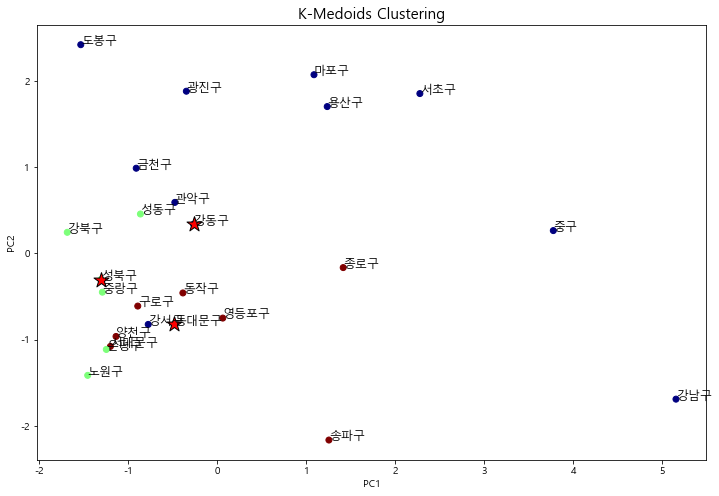

In [40]:
# Kmedoid 시각화 부분 pca
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12,8))
plt.scatter(values_pca[:,0], values_pca[:,1], c=kmedoids.labels_, cmap='jet')
plt.scatter(kmedoids.cluster_centers_[:3, 0], kmedoids.cluster_centers_[:3, 1], s=250, marker='*', c='red', edgecolor='black',
    label='centroids'
)
for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('K-Medoids Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

- 용산구, 서초구, 마포구, 도봉구, 금천구, 관악구, 광진구, 강남구, 중구, 강서구, 강동구(CLUSTER=0)
- 노원구, 성북구, 강북구, 중랑구, 성동구, 은평구(CLUSTER=1)
- 동대문구, 구로구, 영등포구, 양천구, 서대문구, 송파구, 종로구, 동작구(CLUSTER=2)

In [41]:
k2cluster0 = df_k2table[df_k2table['CLUSTER'] == 0]
k2cluster1 = df_k2table[df_k2table['CLUSTER'] == 1]
k2cluster2 = df_k2table[df_k2table['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

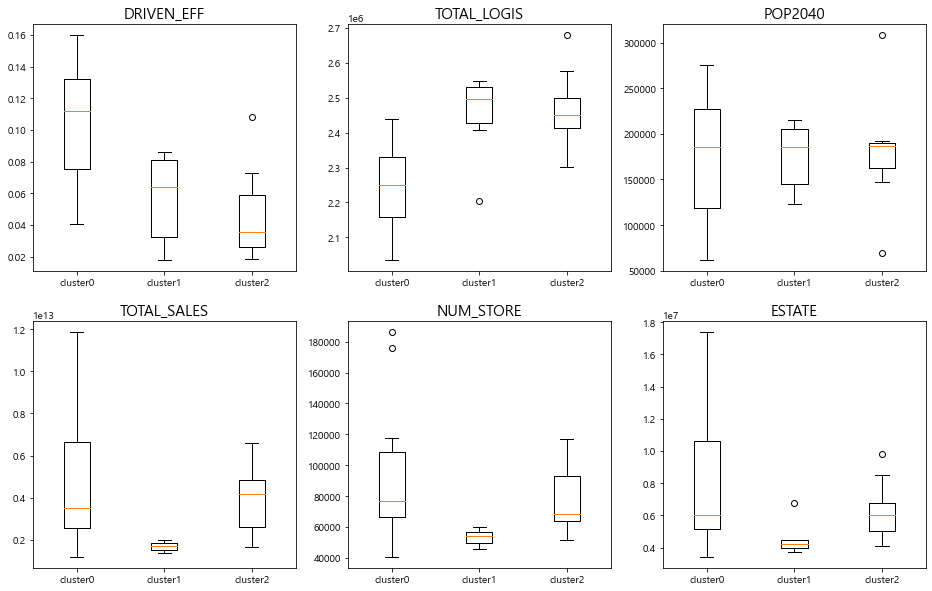

In [42]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
# ax7 = fig.add_subplot(4,3,7)
# ax8 = fig.add_subplot(4,3,8)
# ax9 = fig.add_subplot(4,3,9)
# ax10 = fig.add_subplot(4,3,10)



ax1.boxplot([k2cluster0.DRIVEN_EFF, k2cluster1.DRIVEN_EFF, k2cluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([k2cluster0.TOTAL_LOGIS, k2cluster1.TOTAL_LOGIS, k2cluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([k2cluster0.POP2040, k2cluster1.POP2040, k2cluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([k2cluster0.TOTAL_SALES, k2cluster1.TOTAL_SALES, k2cluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([k2cluster0.NUM_STORE, k2cluster1.NUM_STORE, k2cluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([k2cluster0.ESTATE, k2cluster1.ESTATE, k2cluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

In [43]:
k2cluster2.DISTRICT.unique()

array(['동대문구', '구로구', '영등포구', '양천구', '서대문구', '송파구', '종로구', '동작구'],
      dtype=object)

### K-medoid Clustering Analysis Result
- cluster0
    - 인구수가 가장 많으며 상권과 오프라인 소비력이 가장 크기 때문에 언택트 소비량이 작을 것으로 예상됨
    - 물류량이 가장 작으며 운행 효율이 높기 때문에 현재 물류 서비스가 잘 실행되고 있다고 볼 수 있음
    - 공시지가와 그 폭이 가장 크다 -> MFC 입지에 부적합
   
- cluster1 
    - 물류량, 인구 수 모두 준수
    - 상권 크기가 작으므로 언택트 소비를 기대할 수 있음
    - 공시지가는 가장 낮으며 운행 효율이 좋지 못함 -> MFC 입지로 나쁘지 않음
    
- cluster2 
    - 물류량, 인구 수 모두 준수 
    - 공시지가가 cluster1보다 높지만, 운행 효율이 가장 낮고 매출액과 상권 규모가 cluster1보다 큼 -> MFC 입지에 적합

#### 따라서 cluster2이 MFC입지에 가장 적합

## GMM(Gausian Mixture Model)

In [44]:
from matplotlib import patches
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

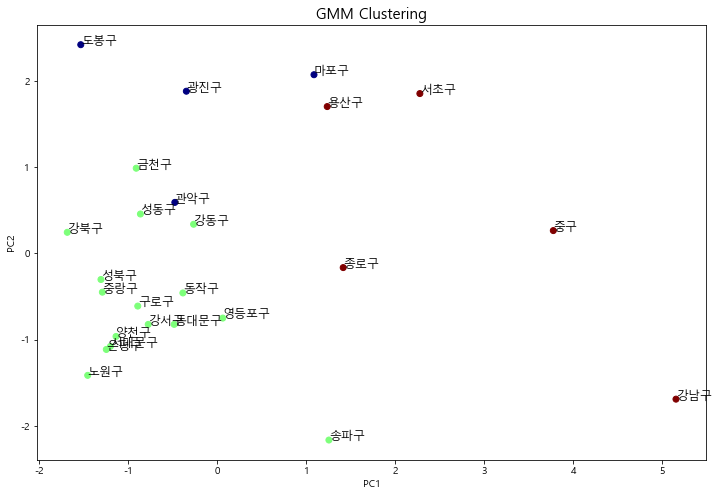

In [45]:
gmm = GaussianMixture(n_components=3, random_state=100)
gmm.fit(values_pca) # GMM 클러스터링 수행
labels = gmm.predict(values_pca) # 최종 클러스터 라벨링

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(12,8))
fig.set_facecolor('white')
plt.scatter(values_pca[:,0], values_pca[:,1], c=labels, cmap='jet')

for i in range(len(principalDf)): 
    row = principalDf.iloc[i]
    name = row['DISTRICT'] 
    x = row['PC1'] 
    y = row['PC2'] 

    plt.text(x, y, name, size=12)
plt.title('GMM Clustering', size=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

- 도봉구, 금천구(CLUSTER=0)
- 동대문구, 구로구, 노원구, 성북구, 강북구, 영등포구, 중랑구, 관악구, 광진구, 양천구, 서대문구, 강서구, 강동구, 성동구, 동작구, 은평구(CLUSTER=1)
- 용산구, 서초구, 마포구, 강남구, 중구, 송파구, 종로구(CLUSTER=2)

In [46]:
labels

array([1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1], dtype=int64)

In [47]:
df_gtable = df_table.copy()

In [48]:
df_gtable['CLUSTER'] = labels

In [49]:
df_gtable

,DISTRICT,DRIVEN_EFF,TOTAL_LOGIS,POP2040,TOTAL_SALES,NUM_STORE,ESTATE,CLUSTER
0,동대문구,0.027219,2400374,166805,4.447564e+12,66655,5198000,1
1,용산구,0.131360,2250955,112398,6.805869e+12,62840,10079000,2
2,구로구,0.054334,2442377,184583,2.806535e+12,69651,4109000,1
3,노원구,0.026526,2507172,215172,1.834499e+12,57391,3911000,1
4,서초구,0.159699,2165093,185381,6.456707e+12,117682,11141000,2
5,마포구,0.142776,2067762,191766,4.087616e+12,99849,9213000,0
6,성북구,0.082233,2484878,199990,1.380648e+12,52834,4507000,1
7,강북구,0.017854,2202978,122596,1.482913e+12,48726,3705000,1
8,도봉구,0.111866,2034893,126118,1.210447e+12,40786,3451000,0
9,금천구,0.066146,2201708,111478,3.490343e+12,55524,3870000,1


In [50]:
gcluster0 = df_gtable[df_gtable['CLUSTER'] == 0]
gcluster1 = df_gtable[df_gtable['CLUSTER'] == 1]
gcluster2 = df_gtable[df_gtable['CLUSTER'] == 2]

Text(0.5, 1.0, 'ESTATE')

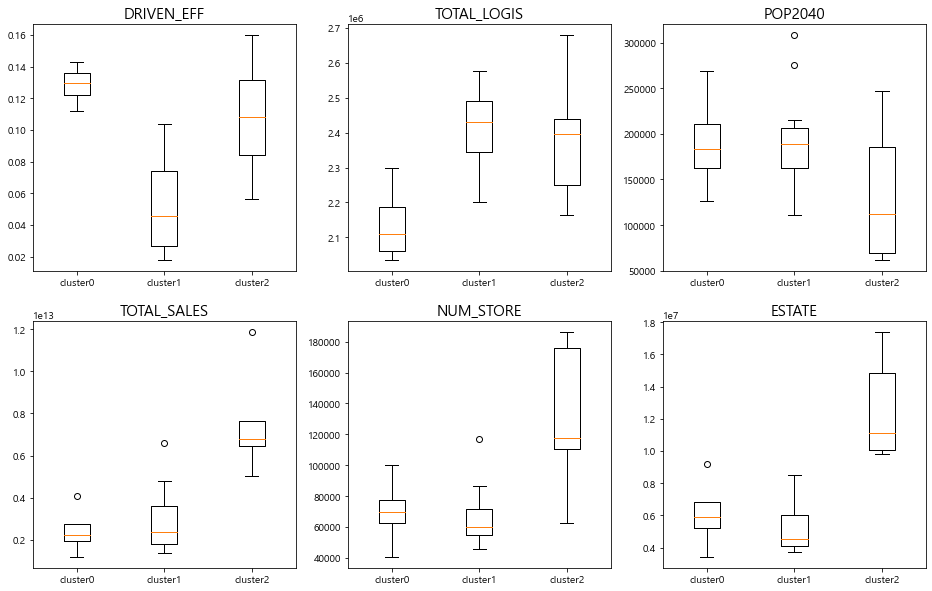

In [51]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)
# ax7 = fig.add_subplot(4,3,7)
# ax8 = fig.add_subplot(4,3,8)
# ax9 = fig.add_subplot(4,3,9)
# ax10 = fig.add_subplot(4,3,10)



ax1.boxplot([gcluster0.DRIVEN_EFF, gcluster1.DRIVEN_EFF, gcluster2.DRIVEN_EFF], labels=['cluster0','cluster1','cluster2']) # DRIVEN_EFF 비교
ax1.set_title('DRIVEN_EFF', size=15)
ax2.boxplot([gcluster0.TOTAL_LOGIS, gcluster1.TOTAL_LOGIS, gcluster2.TOTAL_LOGIS], labels=['cluster0','cluster1','cluster2'])# TOTAL_LOGIS 비교
ax2.set_title('TOTAL_LOGIS', size=15)
ax3.boxplot([gcluster0.POP2040, gcluster1.POP2040, gcluster2.POP2040], labels=['cluster0','cluster1','cluster2'])# POP2040 비교
ax3.set_title('POP2040', size=15)
ax4.boxplot([gcluster0.TOTAL_SALES, gcluster1.TOTAL_SALES, gcluster2.TOTAL_SALES], labels=['cluster0','cluster1','cluster2'])# TOTAL_SALES 비교
ax4.set_title('TOTAL_SALES', size=15)
ax5.boxplot([gcluster0.NUM_STORE, gcluster1.NUM_STORE, gcluster2.NUM_STORE], labels=['cluster0','cluster1','cluster2'])# NUM_STORE 비교
ax5.set_title('NUM_STORE', size=15)
ax6.boxplot([gcluster0.ESTATE, gcluster1.ESTATE, gcluster2.ESTATE], labels=['cluster0','cluster1','cluster2'])# ESTATE 비교
ax6.set_title('ESTATE', size=15)

In [52]:
gcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'], dtype=object)

### GMM Clustering Analysis Result

- cluster0
    - 공시지가는 낮고 인구수는 준수 
    - 물동량이 가장 작으며 운행 효율이 높기 때문에 이미 물류 서비스율이 높다고 할 수 있음 -> MFC 입지에 부적합

- cluster1
    - 물동량 및 인구수 준수
    - 상권 크기가 작아 언택트 소비를 기대할 수 있음
    - 공시지가도 낮으며 운행 효율이 낮은 값임 -> MFC 입지에 적합

- cluster2 
    - 물동량이 준수하지만 그 폭이 너무 넓기 때문에 수요가 일정하지 않음
    - 운행 효율이 높고 공시지가가 너무 높음 -> MFC 입지에 부적합

#### 따라서 cluster1이 MFC 입지에 가장 적합

## Consensus

In [53]:
# hierarchy
hcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '영등포구', '중랑구', '관악구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '동작구', '은평구'], dtype=object)

In [54]:
# kmeans
kcluster0.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '관악구',
       '양천구', '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'],
      dtype=object)

In [55]:
# kmedoid
k2cluster1.DISTRICT.unique()

array(['노원구', '성북구', '강북구', '중랑구', '성동구', '은평구'], dtype=object)

In [56]:
# GMM
gcluster1.DISTRICT.unique()

array(['동대문구', '구로구', '노원구', '성북구', '강북구', '금천구', '영등포구', '중랑구', '양천구',
       '서대문구', '송파구', '강서구', '강동구', '성동구', '동작구', '은평구'], dtype=object)

In [57]:
consensus = hcluster1.DISTRICT.unique().tolist() + kcluster0.DISTRICT.unique().tolist() + k2cluster2.DISTRICT.unique().tolist() + gcluster1.DISTRICT.unique().tolist()

[Text(0.5, 1.0, 'Consensus Clustering')]

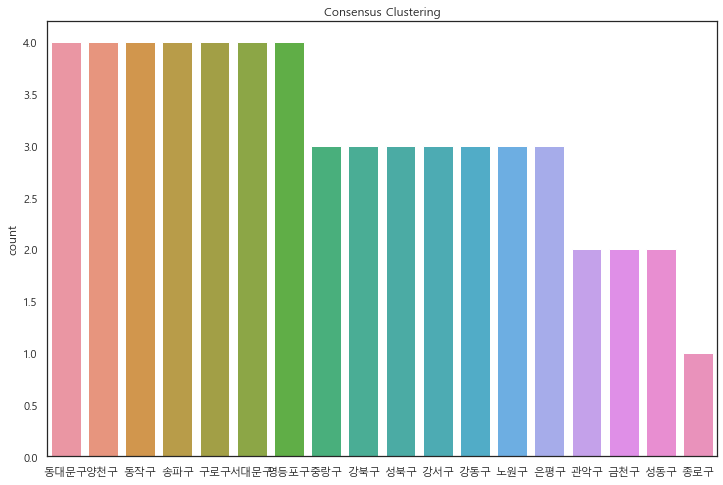

In [58]:
import seaborn as sns
sns.set(font="Malgun Gothic",
rc={"axes.unicode_minus":False, 'figure.figsize':(12,8)}, style='white')
sns.countplot(consensus, order = pd.Series(consensus).value_counts().index).set(title='Consensus Clustering')

**<center>Rank(Candidate District where will be installed MFC)</center>**

|1st|2nd|3rd|4rd|
|------|------|------|-----|
|Dongdaemun|Jungnang|Gwanak|Jongno|
|Yangcheon|Gangbuk|Geumcheon|
|Dongjak|Seongbuk|Seongdong|
|Songpa|Gangseo|
|Guro|Gangdong|
|Seodaemun|Nowon|
|Yeongdeungpo|Eunpyeong|